In [1]:
import concurrent.futures as futures
import requests
import time
import numpy as np
import matplotlib.pyplot as plt
from ailabtools.ailab_multiprocessing import pool_worker

In [2]:
def request_file(url):
    file = open('../benchmark/image.jpg', 'rb')
    start_time = time.time()
    resp = requests.post(url, files={'img_bytes': file}, timeout=3*60*1000)
    return resp.json(), time.time() - start_time


def compute_time(latency, latency_overall, total_request):
    result_dict = {}
#     result_dict['n_requests'] = total_request
    result_dict['n_crashed'] = total_request - len(latency)
    result_dict['n_req/s'] = len(latency)/latency_overall
    result_dict['latency_avg'] = np.mean(latency)
    result_dict['latency_max'] = np.max(latency)
    result_dict['latency_min'] = np.min(latency)
    result_dict['latency_overall'] = latency_overall
    return result_dict

def plot_result(later_result):
    def merge_dict(later_result):
        results = {}
        for res in later_result:
            for key, val in res.items():
                results.setdefault(key, []).append(val)
        return results
    
    n_iters = len(later_result)
    later_result = merge_dict(later_result)
    
    fig = plt.figure(figsize=(10, 5))
    legends = []
    for key in later_result.keys():
        plt.plot(range(n_iters), later_result[key], '-o')
        legends.append(key)
    plt.legend(legends, loc='best')
    plt.xlabel('Iterations')
    plt.xticks(range(0, n_iters), range(1, n_iters+1))
    plt.grid(True)
    plt.show()

In [3]:
url = 'http://0.0.0.0:8000/predict_img_bytes'
n_clients = 500

In [4]:
def bench(url, n_clients):
    results = []
    latencies = []
    start_time = time.time()
    with futures.ThreadPoolExecutor(max_workers=n_clients) as executor:
        req_futures = []
        for _ in range(n_clients):
            f = executor.submit(request_file, url)
            req_futures.append(f)
            
        for future in futures.as_completed(req_futures):
            try:
                data, latency = future.result()
                results.append(data)
                latencies.append(latency)                
            except Exception as exc:
                print('generated an exception: %s' % (exc))
    result_dict = compute_time(latencies, latency_overall=time.time()-start_time, total_request=n_clients)
    return result_dict

In [ ]:
iterations = 10
later_results = []
for _ in range(iterations):
    results = bench(n_clients)
    later_results.append(results)

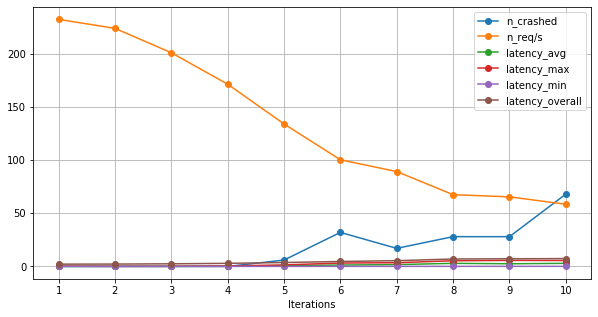

In [6]:
plot_result(later_results)

In [17]:
def bench(url, n_clients):
    start_time = time.time()
    ret = pool_worker(target=request_file, inputs=[url]*n_clients, use_thread=True)
    end_time = time.time()
    latencies = [t[1] for t in ret]
    result_dict = compute_time(latencies, latency_overall=end_time-start_time, total_request=n_clients)
    return ret, result_dict

In [21]:
ret = bench(url, n_clients)

100%|██████████| 500/500 [00:03<00:00, 155.49it/s]


In [22]:
iterations = 5
later_results = []
for _ in range(iterations):
    ret, results = bench(url, n_clients)
    later_results.append(results)

100%|██████████| 500/500 [00:07<00:00, 68.38it/s]


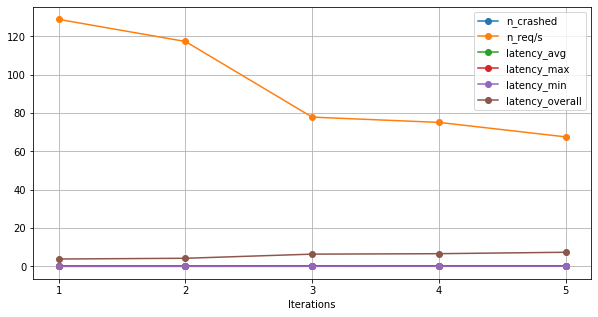

In [23]:
plot_result(later_results)

In [16]:
request_file(url)

({'data': [3, 3], 'error_code': 0, 'error_message': 'Successful.'},
 0.04203486442565918)